## Load and Install Relevant Stuff

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goemotions-sentiment-classification/test.tsv
/kaggle/input/goemotions-sentiment-classification/dev.tsv
/kaggle/input/goemotions-sentiment-classification/lexical.csv
/kaggle/input/goemotions-sentiment-classification/train.tsv
/kaggle/input/goemotions-sentiment-classification/synctatic.csv
/kaggle/input/goemotions-sentiment-classification/semantic.csv
/kaggle/input/goemotions-devtest-features/dev_features.csv
/kaggle/input/goemotions-devtest-features/test_features.csv
/kaggle/input/goemotions-sentiment/emotions.txt


In [2]:
! pip install xgboost

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.stem import WordNetLemmatizer
import string
from umap import UMAP
import umap.plot
from scipy import sparse
from scipy import hstack

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Set Random State

In [6]:
seed = 42
np.random.seed(seed)

## Dataset Categories

In [7]:
train = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/train.tsv', sep='\t',header = None)
train.columns = ["text", "emotion_id", "comment_id"]
train.head()

,text,emotion_id,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [8]:
labels = pd.read_csv('/kaggle/input/goemotions-sentiment/emotions.txt', header = None)
labels = labels.to_dict()[0]

In [9]:
def get_emotion(num):
  num_list = num.split(",")
  emotion_list = [labels[int(i)] for i in num_list]
  return ",".join(emotion_list)
train['emotion'] = train['emotion_id'].apply(get_emotion)

In [10]:
def get_num_emotion(num):
  num_list = num.split(",")
  return len(num_list)
train['num_of_emotion'] = train['emotion_id'].apply(get_num_emotion)

In [11]:
train.head()

,text,emotion_id,comment_id,emotion,num_of_emotion
0,My favourite food is anything I didn't have to...,27,eebbqej,neutral,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,neutral,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,anger,1
3,To make her feel threatened,14,ed7ypvh,fear,1
4,Dirty Southern Wankers,3,ed0bdzj,annoyance,1


Text(0.5, 1.0, 'Distribution of Multiple Emotion Labels')

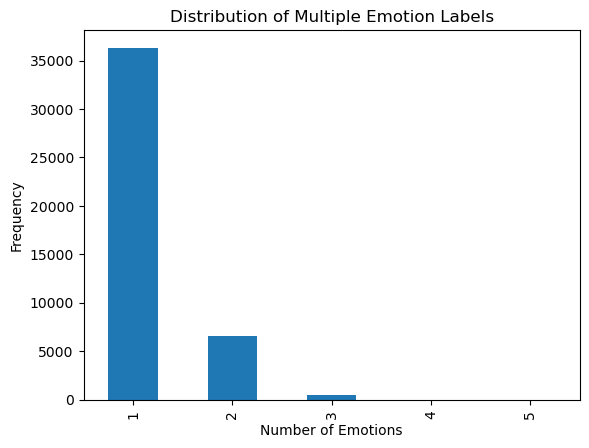

In [12]:
train['num_of_emotion'].value_counts().plot(kind='bar')
plt.xlabel("Number of Emotions")
plt.ylabel("Frequency")
plt.title("Distribution of Multiple Emotion Labels")

<AxesSubplot:>

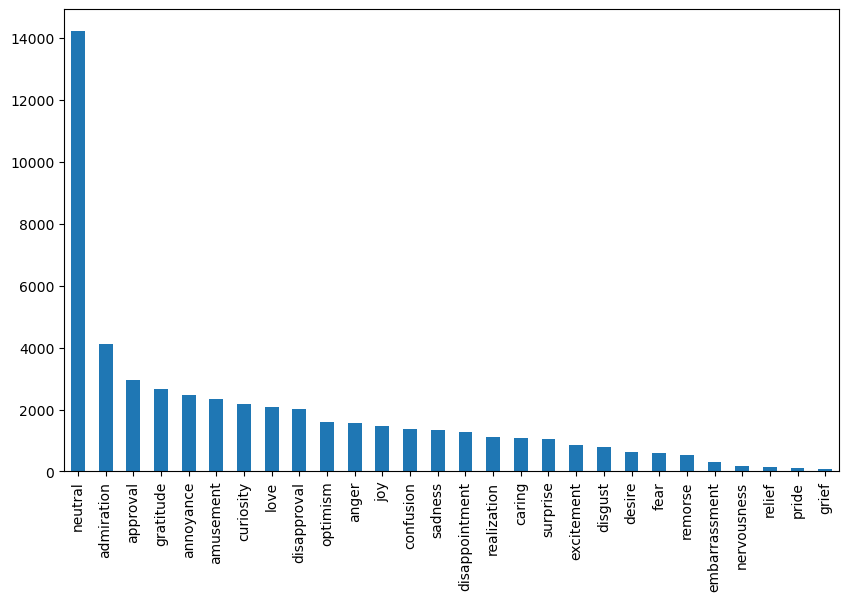

In [13]:
emotions_dummied = train['emotion'].str.get_dummies(',')
emotions_dummied.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,6))

In [14]:
ekman_dict = {
    "anger": "anger",
    "annoyance": "anger",
    "disapproval": "anger",
    "disgust": "disgust",
    "fear": "fear",
    "nervousness": "fear",
    "joy": "joy",
    "amusement": "joy",
    "approval": "joy",
    "excitement": "joy",
    "gratitude": "joy",
    "love": "joy",
    "optimism": "joy",
    "relief": "joy",
    "pride": "joy",
    "admiration": "joy",
    "desire": "joy",
    "caring": "joy",
    "sadness": "sadness",
    "disappointment": "sadness",
    "embarrassment": "sadness",
    "grief": "sadness",
    "remorse": "sadness",
    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",
    "curiosity": "surprise",
    "neutral": "neutral"
}

In [15]:
def convert_to_ekman(text):
  em_list = text.split(",")
  ek_list = []
  for i in em_list:
    ek = ekman_dict[i] 
    if ek not in ek_list:
      ek_list.append(ek)
  return ",".join(ek_list)
train["ekman_emotion"] = train["emotion"].apply(convert_to_ekman)
train["ekman_num"] = train["ekman_emotion"].apply(get_num_emotion)

Text(0.5, 1.0, 'Distribution of Multiple Emotion Labels')

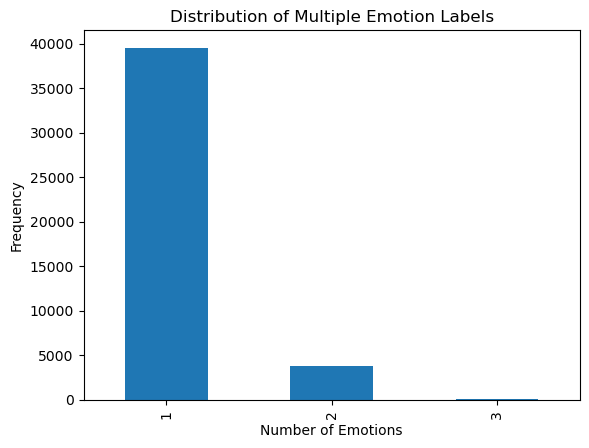

In [16]:
train['ekman_num'].value_counts().plot(kind='bar')
plt.xlabel("Number of Emotions")
plt.ylabel("Frequency")
plt.title("Distribution of Multiple Emotion Labels")

<AxesSubplot:>

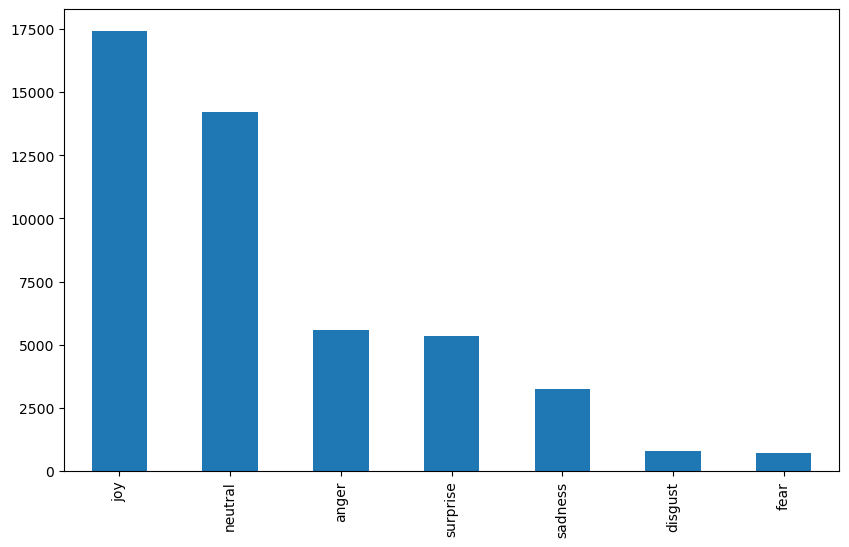

In [17]:
ekman_dummied = train['ekman_emotion'].str.get_dummies(',')
ekman_dummied.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,6))

In [63]:
train.iloc[[7, 15, 19, 30, 0], [0,3,5]].to_csv('example.csv') # 7, 15, 19, 3, 0

## Prepare Data for ML Models

In [22]:
semantic = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/semantic.csv')
semantic = semantic.iloc[:, 1:]
lexical = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/lexical.csv')
lexical = lexical.iloc[:, 1:]
synctatic = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/synctatic.csv')
synctatic = synctatic.iloc[:, 1:]

In [23]:
semantic.shape, lexical.shape, synctatic.shape

((43410, 6), (43410, 5), (43410, 3))

In [24]:
# dummy encode tense 
# drop unknown tense to prevent overdetermined
tense_encoded = synctatic['tense'].str.get_dummies().drop('UNKNOWN', axis=1)
synctatic = pd.concat([synctatic, tense_encoded], axis=1).drop('tense', axis=1)

In [25]:
features = pd.concat([synctatic, lexical, semantic], axis=1)
features.describe()

,pronoun_frequency,np_vp_ratio,FUTURE_SIMPLE,PAST_SIMPLE,PRESENT_CONTINUOUS,PRESENT_SIMPLE,PRESENT_SIMPLE_PLURAL,stop_word_ratio,unique_token_ratio,punctation_intensity,digit_ratio,upper_lower_ratio,polarity,subjectivity,neg,neu,pos,compound
count,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000,43410.000000
mean,0.100844,2.648961,0.004584,0.312946,0.040820,0.266413,0.245266,0.315783,0.934597,0.536675,0.006758,0.385890,0.095777,0.446855,0.106700,0.703159,0.190004,0.128239
std,0.084235,1.825433,0.067552,0.463698,0.197875,0.442088,0.430250,0.139548,0.080635,0.399214,0.027156,3.323293,0.351424,0.335991,0.156513,0.217598,0.208451,0.469776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.007042,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.982900
25%,0.034483,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.241379,0.892857,0.000000,0.000000,0.045455,0.000000,0.066667,0.000000,0.562000,0.000000,-0.200300
50%,0.095238,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.952381,0.666667,0.000000,0.072289,0.000000,0.500000,0.000000,0.710000,0.146000,0.007400
75%,0.153846,3.333333,0.000000,1.000000,0.000000,1.000000,0.000000,0.409091,1.000000,0.750000,0.000000,0.125000,0.300000,0.700000,0.185000,0.864000,0.313000,0.526700
max,0.666667,47.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,0.604651,116.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985600


<AxesSubplot:>

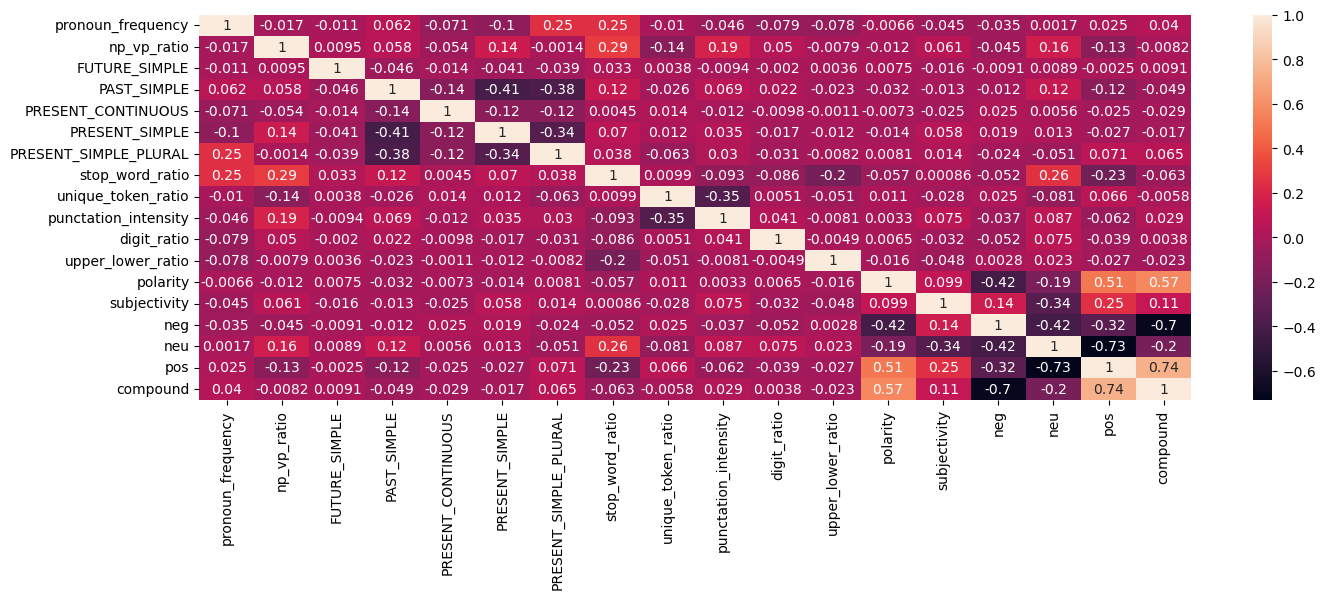

In [26]:
plt.figure(figsize = (16,5))
sns.heatmap(features.corr(), annot=True)

## Preprocessing for TFIDF

In [27]:
stop_words = stopwords.words('english') + ["n't"]
lemmatizer = WordNetLemmatizer()
punct_table = str.maketrans('', '', string.punctuation + "’")

In [28]:
def clean_text(text):
  text = text.lower()
  words = nltk.word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  lemmas = ' '.join(lemmas)
  return lemmas.translate(punct_table)

In [29]:
train['cleaned_text'] = train['text'].apply(clean_text)

## TFIDF

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)

In [31]:
X_train = vectorizer.fit_transform(train['cleaned_text']) # 

In [32]:
X_train.shape

(43410, 24734)

In [33]:
y_train = ekman_dummied

In [34]:
y_train

,anger,disgust,fear,joy,neutral,sadness,surprise
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
43405,0,0,0,1,0,0,0
43406,0,0,0,0,0,0,1
43407,1,0,0,0,0,0,0
43408,0,0,0,1,0,0,0


## Loading & Processing Dev Data

In [35]:
# load dev data
dev = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/dev.tsv', sep='\t',header = None)
dev.columns = ["text", "emotion_id", "comment_id"]
dev.head()

,text,emotion_id,comment_id
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [36]:
dev["ekman_emotion"] = (dev['emotion_id'].apply(get_emotion)).apply(convert_to_ekman)
dev.head()

,text,emotion_id,comment_id,ekman_emotion
0,Is this in New Orleans?? I really feel like th...,27,edgurhb,neutral
1,"You know the answer man, you are programmed to...","4,27",ee84bjg,"joy,neutral"
2,I've never been this sad in my life!,25,edcu99z,sadness
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2,"joy,neutral"
4,He could have easily taken a real camera from ...,20,eepig6r,joy


In [37]:
y_dev = dev['ekman_emotion'].str.get_dummies(',')
dev['cleaned_text'] = dev['text'].apply(clean_text)

In [41]:
dev['ekman_emotion'].str.get_dummies(',').sum()

anger        717
disgust       97
fear         105
joy         2219
neutral     1766
sadness      390
surprise     624
dtype: int64

Convert X_dev to TFIDF vector. Note that the models used on the train data, i.e. ``vectorizer`` are the same ones used on the test/dev to prevent data leakage.

In [38]:
X_dev = vectorizer.fit(train['cleaned_text']).transform(dev['cleaned_text'])

In [39]:
dev_features = pd.read_csv('/kaggle/input/goemotions-devtest-features/dev_features.csv', sep=',',header = 0)
dev_features = dev_features.iloc[:, 1:]
tense_encoded = dev_features['tense'].str.get_dummies().drop('UNKNOWN', axis=1)
dev_features = pd.concat([dev_features, tense_encoded], axis=1).drop('tense', axis=1)
dev_features.head()

,polarity,subjectivity,neg,neu,pos,compound,stop_word_ratio,unique_token_ratio,punctation_intensity,digit_ratio,upper_lower_ratio,pronoun_frequency,np_vp_ratio,FUTURE_SIMPLE,PAST_SIMPLE,PRESENT_CONTINUOUS,PRESENT_SIMPLE,PRESENT_SIMPLE_PLURAL
0,0.157576,0.369697,0.000,0.778,0.222,0.4833,0.250000,0.750000,1.000000,0.0,0.159091,0.062500,6.000000,0,0,0,1,0
1,0.000000,0.000000,0.128,0.872,0.000,-0.3595,0.434783,0.913043,0.666667,0.0,0.025641,0.217391,1.400000,0,0,0,0,1
2,-0.625000,1.000000,0.359,0.641,0.000,-0.6016,0.400000,1.000000,0.500000,0.0,0.074074,0.200000,4.000000,0,1,0,0,0
3,-0.200000,0.500000,0.091,0.909,0.000,-0.3182,0.370370,0.962963,0.666667,0.0,0.056604,0.037037,4.000000,0,1,0,0,0
4,0.316667,0.566667,0.000,0.893,0.107,0.3400,0.458333,0.916667,0.500000,0.0,0.039604,0.083333,3.333333,0,1,0,0,0


In [44]:
# order
dev_features = dev_features[["pronoun_frequency", "np_vp_ratio", "FUTURE_SIMPLE", "PAST_SIMPLE", "PRESENT_CONTINUOUS", "PRESENT_SIMPLE", "PRESENT_SIMPLE_PLURAL", "stop_word_ratio", "unique_token_ratio", "punctation_intensity", "digit_ratio", "upper_lower_ratio", "polarity", "subjectivity", "neg", "neu", "pos", "compound"]]

## Model Creation/Hyperparameter Tuning on Baseline

In [45]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def multilabel_accuracy(y_true, y_pred):
    # Convert inputs to numpy arrays, if they are not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate element-wise equality between true and predicted labels
    element_wise_equality = np.equal(y_true, y_pred)

    # Calculate the fraction of correctly predicted labels across all samples
    accuracy = np.mean(element_wise_equality)

    return accuracy

Things to consider:
1. Algorithm - Transformation (classifier chain) / original algorithm if sklearn allows for it
2. Handling Class Imbalance - not much to do other than make weights balanced
3. Error Metrics - Subset Accuracy, Accuracy, Regular F1, Actual F1
4. Hyperparameter tuning

In [ ]:
def build_model(classifier, X_train, X_dev, y_train, y_dev):
        
    start_time = time.time()
    classifier.fit(X_train, y_train)
    train_time = time.time() - start_time

    # predict
    start_time = time.time()
    predictions = classifier.predict(X_dev)
    predict_time = time.time() - start_time

    # accuracy
    print("Subset accuracy = ", accuracy_score(y_dev,predictions))
    print("Multilabel accuracy = ", multilabel_accuracy(y_dev,predictions))
    print("Hamming Loss =", hamming_loss(y_dev,predictions))
    print("Micro F1 =", f1_score(y_dev,predictions, average='micro'))
    
    print()
    print("Time taken to train: {:.2f} seconds".format(train_time))
    print("Time taken to predict: {:.2f} seconds".format(predict_time))
        
    return [accuracy_score(y_dev,predictions), multilabel_accuracy(y_dev,predictions), \
            hamming_loss(y_dev,predictions), f1_score(y_dev,predictions, average='micro')]

### Baseline (Just TFIDF)

In [ ]:
# Logistic Regression
log_classifier = ClassifierChain(LogisticRegression(class_weight='balanced', max_iter=500, random_state=seed))
build_model(log_classifier, X_train, X_dev, y_train, y_dev)

In [ ]:
# SVM - SGD approximates LinearSVC using hinge loss
svm_classifier = ClassifierChain(SGDClassifier(class_weight='balanced', loss='hinge', random_state=seed))
build_model(svm_classifier, X_train, X_dev, y_train, y_dev)

In [ ]:
# KNN - cosine
knn_classifier_b = KNeighborsClassifier(metric='cosine', n_jobs=-1)
build_model(knn_classifier_b, X_train, X_dev, y_train, y_dev)

In [ ]:
# Random Forest
rf_classifier = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=seed)
build_model(rf_classifier, X_train, X_dev, y_train, y_dev)

In [ ]:
# XGBoost 
xgb_classifier = XGBClassifier(seed=seed)
build_model(xgb_classifier, X_train, X_dev, y_train, y_dev)

### TFIDF + All features

Based on #3 in the 1st stackexchange answer: [here](https://datascience.stackexchange.com/questions/987/text-categorization-combining-different-kind-of-features)

In [ ]:
from sklearn.model_selection import cross_val_predict

Steps
1. Create a model using *only* sparse text data (use best performing model from above, i.e. Random Forests)
2. Use the predicted probabilites of the positive class as a dense feature with other (scaled/not scaled?) dense features (i.e. the feature data we calculated) to create a model (ie: ensembling via stacking). 

In [ ]:
X_train.shape, y_train.shape

In [ ]:
len(best_model.predict_proba(X_dev))

In [ ]:
def get_preds(best_model, X_train, y_train, X_dev, y_dev):
    best_model.fit(X_train, y_train)
    
    # get predicted probabilities from train data using cross validation
    start_time = time.time()
    train_preds = cross_val_predict(best_model, X_train, y_train, cv=3, method='predict_proba', n_jobs=-1)
    val_time = time.time() - start_time
    print("Validation Time", val_time)
    
    # get predicted probabilities of test data
    test_preds = best_model.predict_proba(X_dev)  
    
    return train_preds, test_preds

In [ ]:
# this takes a while to run (~5 minutes)
best_model = rf_classifier
train_preds, test_preds = get_preds(best_model, X_train, y_train, X_dev, y_dev)

In [ ]:
# extract the 7 predicted positive probabilites from train_preds & test_preds
def get_predicted_probabilites(train_preds, test_preds):
    train_preds_list, test_preds_list = [], []
    for idx in range(7):
        train_preds_list.append(train_preds[idx][:, 1])
        test_preds_list.append(test_preds[idx][:, 1])
    train_preds = np.transpose(np.array(train_preds_list))
    test_preds = np.transpose(np.array(test_preds_list))
    return train_preds, test_preds

In [ ]:
train_preds, test_preds = get_predicted_probabilites(train_preds, test_preds)

This function can be used to test different features and different models

In [ ]:
def test_features(train_features, test_features, model, train_preds, test_preds, y_train, y_dev):
    X_train_extensive = np.hstack((train_features.values, train_preds))
    X_dev_extensive = np.hstack((test_features.values, test_preds))
    
    return build_model(model, X_train_extensive, X_dev_extensive, y_train, y_dev)

In [ ]:
features.head()

In [ ]:
dev_features.head()

In [ ]:
test_features(features, dev_features, log_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(features, dev_features, svm_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
knn_classifier_f = KNeighborsClassifier(metric='manhattan', n_jobs=-1)
test_features(features, dev_features, knn_classifier_f, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(features, dev_features, rf_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(features, dev_features, xgb_classifier, train_preds, test_preds, y_train, y_dev)

## TFIDF + Semantic

In [ ]:
semantic_f = ['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']

In [ ]:
semantic_features = features.drop(features[semantic_f], axis=1)
semantic_dev_features = dev_features.drop(dev_features[semantic_f], axis=1)

In [ ]:
test_features(semantic_features, semantic_dev_features, log_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(semantic_features, semantic_dev_features, svm_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(semantic_features, semantic_dev_features, knn_classifier_f, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(semantic_features, semantic_dev_features, rf_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(semantic_features, semantic_dev_features, xgb_classifier, train_preds, test_preds, y_train, y_dev)

## TFIDF + Lexical

In [ ]:
lexical_f = ['stop_word_ratio', 'unique_token_ratio', 'punctation_intensity', 'digit_ratio', 'upper_lower_ratio']

In [ ]:
lexical_features = features.drop(features[lexical_f], axis=1)
lexical_dev_features = dev_features.drop(dev_features[lexical_f], axis=1)

In [ ]:
test_features(lexical_features, lexical_dev_features, log_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(lexical_features, lexical_dev_features, svm_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(lexical_features, lexical_dev_features, knn_classifier_f, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(lexical_features, lexical_dev_features, rf_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(lexical_features, lexical_dev_features, xgb_classifier, train_preds, test_preds, y_train, y_dev)

## TFIDF + Synctatic

In [ ]:
synctatic_f = ['pronoun_frequency', 'np_vp_ratio', 'FUTURE_SIMPLE', 'PAST_SIMPLE', 'PRESENT_CONTINUOUS', 'PRESENT_SIMPLE', 'PRESENT_SIMPLE_PLURAL']

In [ ]:
synctatic_features = features.drop(features[synctatic_f], axis=1)
synctatic_dev_features = dev_features.drop(dev_features[synctatic_f], axis=1)

In [ ]:
test_features(synctatic_features, synctatic_dev_features, log_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(synctatic_features, synctatic_dev_features, svm_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(synctatic_features, synctatic_dev_features, knn_classifier_f, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(synctatic_features, synctatic_dev_features, rf_classifier, train_preds, test_preds, y_train, y_dev)

In [ ]:
test_features(synctatic_features, synctatic_dev_features, xgb_classifier, train_preds, test_preds, y_train, y_dev)

## Tests on Test Data (*ONLY RUN ONCE*)

In [46]:
test = pd.read_csv('/kaggle/input/goemotions-sentiment-classification/test.tsv', sep='\t',header = None)
test.columns = ["text", "emotion_id", "comment_id"]
test["ekman_emotion"] = (test['emotion_id'].apply(get_emotion)).apply(convert_to_ekman)
y_test = test['ekman_emotion'].str.get_dummies(',')
test['cleaned_text'] = test['text'].apply(clean_text)
test.head()

,text,emotion_id,comment_id,ekman_emotion,cleaned_text
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,sadness,really sorry situation although love name s...
1,It's wonderful because it's awful. At not with.,0,ed5f85d,joy,s wonderful s awful
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,joy,king fan good luck guy interesting game watch
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,joy,know thank teaching something today
4,They got bored from haunting earth for thousan...,27,eem5uti,neutral,got bored haunting earth thousand year ultimat...


In [50]:
test['ekman_emotion'].str.get_dummies(',').sum()

anger        726
disgust      123
fear          98
joy         2104
neutral     1787
sadness      379
surprise     677
dtype: int64

In [47]:
y_test

,anger,disgust,fear,joy,neutral,sadness,surprise
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
5422,0,0,0,1,0,0,0
5423,0,0,0,1,0,0,0
5424,0,0,0,0,1,0,0
5425,0,0,0,1,0,0,0


In [48]:
X_test = vectorizer.transform(test['cleaned_text'])
X_test

<5427x24734 sparse matrix of type '<class 'numpy.float64'>'
	with 32500 stored elements in Compressed Sparse Row format>

In [49]:
X_test.shape, y_test.shape

((5427, 24734), (5427, 7))

In [ ]:
test_features_df = pd.read_csv('/kaggle/input/goemotions-devtest-features/test_features.csv', sep=',',header = 0)
test_features_df = test_features_df.iloc[:, 1:]
tense_encoded = test_features_df['tense'].str.get_dummies().drop('UNKNOWN', axis=1)
test_features_df = pd.concat([test_features_df, tense_encoded], axis=1).drop('tense', axis=1)
test_features_df = test_features_df[["pronoun_frequency", "np_vp_ratio", "FUTURE_SIMPLE", "PAST_SIMPLE", "PRESENT_CONTINUOUS", "PRESENT_SIMPLE", "PRESENT_SIMPLE_PLURAL", "stop_word_ratio", "unique_token_ratio", "punctation_intensity", "digit_ratio", "upper_lower_ratio", "polarity", "subjectivity", "neg", "neu", "pos", "compound"]]
test_features_df.head()

In [ ]:
test_features_df.shape

In [ ]:
metrics = ['Subset Accuracy', 'Multilabel Accuracy', 'Hamming Loss','Micro F1']
classifier_names = ['Logistic Regression', 'SVM', 'KNN', 'Random Forests', 'XGBoost']

In [ ]:
# baseline
test_results_baseline_df = pd.DataFrame(columns=metrics, index=classifier_names)
classifiers = [log_classifier, svm_classifier, knn_classifier_b, rf_classifier, xgb_classifier]

In [ ]:
test_results_baseline_df

In [ ]:
for idx, classifier in enumerate(classifiers):
    print(classifier)
    test_results_baseline_df.iloc[idx] = build_model(classifier, X_train, X_test, y_train, y_test)

In [ ]:
test_results_baseline_df

In [ ]:
# prep for feature testing
classifiers = [log_classifier, svm_classifier, knn_classifier_f, rf_classifier, xgb_classifier]

In [ ]:
from scipy.stats import gmean

In [ ]:
# use gmean of metrics accuracy/f1 metrics + inverse of hamming loss to determine best classifier
gmean(test_results_baseline_df[['Subset Accuracy', 'Multilabel Accuracy', 'Micro F1']].astype(float), axis=1)

*Balanced Multilabel Performance (BMP) Score*: A way to combine all the metrics together. Value between 0 and 1. 0 is bad, 1 is good: $$(\frac{1}{2} * \frac{1}{10 * Hamming Loss}) + (\frac{1}{2}*gmean(subset Acc, MLC Acc, Mic F1))$$
This name reflects that the metric is a combination of two components: one that emphasizes the importance of correctly predicting rare labels (the inverse of the Hamming Loss) and another that measures the overall accuracy of the model on the multi-label classification problem (the geometric mean of the accuracy/f1 metrics). 

0.5 -> each half has equal weights. <br>
geometric mean -> favor models that perform well across *all* metrics <br>
10 * HL -> scale between 0 and 1 <br>
inverse -> make higher values mean better performance <br>

In [ ]:
1 / ( 10 * test_results_baseline_df['Hamming Loss'] ) # with inverse, higher is better

In [ ]:
0.5 * (1 / ( 10 * test_results_baseline_df['Hamming Loss'] )) + 0.5 * gmean(test_results_baseline_df[['Subset Accuracy', 'Multilabel Accuracy', 'Micro F1']].astype(float), axis=1)

In [ ]:
# best is RF!

In [ ]:
best_model = rf_classifier
train_preds, test_preds = get_preds(best_model, X_train, y_train, X_test, y_test)

In [ ]:
train_preds, test_preds = get_predicted_probabilites(train_preds, test_preds)

In [ ]:
semantic_test_features = test_features_df.drop(test_features_df[semantic_f], axis=1)
lexical_test_features = test_features_df.drop(test_features_df[lexical_f], axis=1)
synctatic_test_features = test_features_df.drop(test_features_df[synctatic_f], axis=1)

In [ ]:
semantic_test_features.shape

In [ ]:
def test_features_on_test_data(df, classifiers, train_features, test_features_df, train_preds, test_preds, y_train, y_test):
    # for each classifier, compute scores
    for idx, classifier in enumerate(classifiers):
        print(classifier)
        # test_features(train_features, test_features, model, train_preds, test_preds, y_train, y_dev)
        results = test_features(train_features, test_features_df, classifier, train_preds, test_preds, y_train, y_test)
        df.iloc[idx] = results
    # return df
    return df

In [ ]:
test_results_all_df = pd.DataFrame(columns=metrics, index=classifier_names)
test_features_on_test_data(test_results_all_df, classifiers, features, test_features_df, train_preds, test_preds, y_train, y_test)

In [ ]:
test_results_semantic_df = pd.DataFrame(columns=metrics, index=classifier_names)
test_features_on_test_data(test_results_semantic_df,classifiers, semantic_features, semantic_test_features, train_preds, test_preds, y_train, y_test)

In [ ]:
test_results_lexical_df = pd.DataFrame(columns=metrics, index=classifier_names)
test_features_on_test_data(test_results_lexical_df,classifiers, lexical_features, lexical_test_features, train_preds, test_preds, y_train, y_test)

In [ ]:
test_results_synctatic_df = pd.DataFrame(columns=metrics, index=classifier_names)
test_features_on_test_data(test_results_synctatic_df,classifiers, synctatic_features, synctatic_test_features, train_preds, test_preds, y_train, y_test)

In [ ]:
test_results_baseline_df = test_results_baseline_df[['Multilabel Accuracy', 'Micro F1', 'Subset Accuracy', 'Hamming Loss']]
test_results_all_df = test_results_all_df[['Multilabel Accuracy', 'Micro F1', 'Subset Accuracy', 'Hamming Loss']]
test_results_semantic_df = test_results_semantic_df[['Multilabel Accuracy', 'Micro F1', 'Subset Accuracy', 'Hamming Loss']]
test_results_lexical_df = test_results_lexical_df[['Multilabel Accuracy', 'Micro F1', 'Subset Accuracy', 'Hamming Loss']]
test_results_synctatic_df = test_results_synctatic_df[['Multilabel Accuracy', 'Micro F1', 'Subset Accuracy', 'Hamming Loss']]

In [ ]:
# add BMP Score

In [ ]:
dataframes = [test_results_baseline_df, test_results_all_df, test_results_semantic_df, test_results_lexical_df, test_results_synctatic_df]

In [ ]:
plot_titles = ['Baseline', 'All Features', 'Semantic Dropped', 'Lexical Dropped', 'Synctatic Dropped']

In [ ]:
def calculate_bmp(df):
    return 0.5 * (1 / ( 10 * df['Hamming Loss'] )) + 0.5 * gmean(df[['Subset Accuracy', 'Multilabel Accuracy', 'Micro F1']].astype(float), axis=1)

In [ ]:
for df in dataframes:
    df['BMP'] = calculate_bmp(df)

In [ ]:
test_results_baseline_df

## Plot Results

In [ ]:
x_labels = classifier_names

# Create subplots
fig, axes = plt.subplots(nrows=len(dataframes), ncols=1, figsize=(16,20))

# Loop over dataframes and plot each one on a separate subplot
for i, df in enumerate(dataframes):
    df.plot(kind='bar', xticks=range(len(df)), rot=0, ax=axes[i], label=metrics)
    
    # Add bar labels
    for j, bar in enumerate(axes[i].containers):
        axes[i].bar_label(bar, label_type='edge', labels=[np.round(k, 2) for k in df.T.iloc[j].values])

    # Set labels
    axes[i].set_xticklabels([])  
    axes[i].set_xlabel('')
    axes[i].set_title(plot_titles[i])
    axes[i].legend('')
    
axes[-1].set_xticklabels(x_labels)
axes[-1].set_xlabel('Model')

# Add legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig('results.png')
plt.show()

In [ ]:
test_results_baseline_df = test_results_baseline_df.astype(float).round(4)

In [ ]:
test_results_all_df = test_results_all_df.astype(float).round(4)

In [ ]:
test_results_semantic_df = test_results_semantic_df.astype(float).round(4)

In [ ]:
test_results_lexical_df = test_results_lexical_df.astype(float).round(4)

In [ ]:
test_results_synctatic_df = test_results_synctatic_df.astype(float).round(4)

In [ ]:
for idx, df in enumerate(dataframes):
    name = plot_titles[idx] + ".csv"
    df.to_csv(name, index=False)